COMP 215 - LAB 5 (Elementary Cellular Automata)
-----------------------------------------------
#### Name: Watson Li  
#### Date: 06 Feb 2023

This lab exercise is an introduction to the elementary [Cellular Automata](https://en.wikipedia.org/wiki/Elementary_cellular_automaton) studied by [Stephen Wolfram](https://en.wikipedia.org/wiki/Stephen_Wolfram#Complex_systems_and_cellular_automata).

**New Python concepts**:
  * **[NumPy](https://numpy.org)** is an open-source scientific computing package.  We will be using numpy for the remainder of the term.
  * 1D and 2D [array](https://numpy.org/doc/stable/reference/generated/numpy.array.html) -  an rectangular grid with efficient matrix operations.

**New Computation concepts**:
  * **bit sequence** (a.k.a. binary number) - using a sequence of 0's and 1's to efficiently represent a data structure and processes.

**Credits**:
    Code examples based on [Think Complexity, 2nd edition](https://thinkcomplex.com).
    Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

As usual, the first code cell simply imports all the modules we'll be using...

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

## CA Fundamentals
Both the textbook and our week5 notebook develop some fundamental operations for simulating Elementary CA.
Some of the code from `week5.ipynb` is reproduced here without deriving all the ideas - review `week5.ipynb` notebook for the full story.
The sliding dot product algorithm in `rule_indexes` is implemented with [numpy.correlate](https://numpy.org/doc/stable/reference/generated/numpy.correlate.html).  It's behaviour is identical to the derivation in `week5.ipynb`.

#### Notes
* we use `np.pad(array, 1, mode='wrap')` to pad state vector with 1 value on either end from the opposite end of the vector.
* since the rule is an `np.array`, we use "vector indexing" here to index a whole row at once:  next_row=rule[indexes]


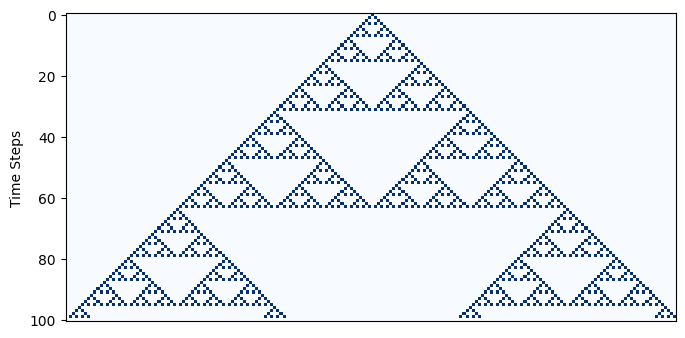

In [30]:
POWERS_OF_2 = np.array((4, 2, 1))

def rule_indexes(state):
    """ Return vector of rule indexes - one index for each 3-cell neighbourhood in the CA state vector. """
    # numpy's version of the "sliding dot product" algorithm;  "pad" ends of state array with extra 0 cell to mitigate edge effects
    return np.correlate(np.pad(state, 1, mode='constant'), POWERS_OF_2, mode='valid')

assert all( rule_indexes(np.array([1,1,0,0,1,0,0,0])) == [3, 6, 4, 1, 2, 4, 0, 0] )


def transition(state, rule):
    """ Return a np.array for the state transition for given CA state under the given 8-bit rule """
    indexes = rule_indexes(state)
    return np.array(rule[indexes])  # "vector indexing" replaces: [rule[i] for i in indexes]

rule_110 = (0,1,1,0,1,1,1,0)[::-1]
assert all( transition(np.array((0,0,1,1,1,0,0,0,1,1,0)), np.array(rule_110)) == (0,1,1,0,1,0,0,1,1,1,0))


# This algorithm is from the textbook - it uses numpy to do a decimal to binary conversion.
def get_lookup_table(rule):
    """
    Return the 8-bit transition vector for the given elementary CA rule number.
    rule: int 0-255
    returns: transition lookup table - a 8 element vector of 0s and 1s
    """
    rule = np.array([rule], dtype=np.uint8)
    return np.unpackbits(rule)[::-1]

assert np.all( get_lookup_table(110) == rule_110 )


def single_centre_array(n_cells):
    """ Return a binary 1D array with given number of cells, all zeros except a single 1 in the centre cell """
    array = np.zeros(n_cells, dtype=np.uint8)
    array[n_cells//2] = 1
    return array

assert np.all( single_centre_array(7) == (0,0,0,1,0,0,0) )


def simulate_ca(n_cells, n_steps, rule):
    """ Generate a CA with given number of cells, plot progression of rule for given number of time steps """
    start_state = single_centre_array(n_cells)
    # stack up one "empty" state vector for each time step
    ca_timesteps = np.vstack([start_state, np.zeros((n_steps, len(start_state)), dtype=np.uint8)])
    for t in range(1, n_steps):
        ca_timesteps[t] = transition(ca_timesteps[t-1], rule)
    return ca_timesteps


def plot_ca(array, title=''):
    """ Plot the 2D CA array as an image.  1's will be dark blue, 0's will be light blue. """
    plt.title(title)
    plt.xticks([])  # turn off x-axis tick marks
    plt.ylabel('Time Steps')  # label y-axis to remind us time runs from top to bottom
    plt.imshow(array, cmap='Blues', interpolation='none')


rule_90 = get_lookup_table(90)
ca_timesteps = simulate_ca(200, 100, rule_90)
plt.subplots(figsize=(8, 4))
plot_ca(ca_timesteps)

## Exercise 1: Additional Start States
In Wolfram's original experiments, he starts with a CA that is all zeros except the centre cell.
This is reproduced by the `single_centre_array` function above.
It would be interesting to experiment with other start states...

Write 2 functions, each of which returns a 1-D `numpy.array` (vector) configured in a specific state:
1. `from_string_array` takes a text string of 0's and 1's and returns a 1D array with matching integer values
2. `random_array` takes a float $ p where 0 <= p <= 1 $ as input and returns a 1D array $a$, where probability $a[i] == 1$ is $p$

*Tip*: both problems are most easilty solved using list comprehensions!

In [31]:
# Solution for Ex. 1 here...
def from_string_array(inputstr):
    return np.array([int(i) for i in inputstr])

def random_array(floatp, arraylen):
    return np.random.choice([0, 1], size=arraylen, p=[1-floatp, floatp])

random_array(0.5, 10)

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 0])

## Exercise 2: A Cell1D class
Develop your own Cell1D class that uses the functions above to implement its fundamental operations.
The `Cell1D` class from the textbook may provide some ideas, but you may find it more confusing than helpful.
The goal here is to improve on the design of that class, so it might be better to just start over...

* Initialize a Cell1D with a `rule` number and an array representing the CA `start_state`
  *Tip*: initialize a 2-D array with just a single row to define the CA's data structure correctly.
* Add a `simulate` method that takes the number of steps to simulate as input (note: my solution is just 4 lines of code)
  *Tip*: use `vstack` to add enough rows onto the CA array prior to looping the simulation forward the given number of steps.
  *Tip*: watch your indexing logic - each subsequent call must start where the last one left off.  There is an elegant solution to this.
* Add a `step` method.  Unlike the textbook, our `step` method is just a convenience method - it just `simulate`s a single step.
* Add a `draw` method.  You could either call on `plot_ca` to do the actual work or copy its code in - your choice.

Note: this is *not* a dataclass - you will need to initialzice objects with an `__init__` method.

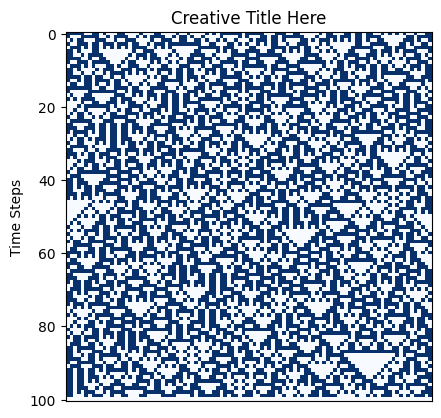

In [66]:
# Solution for Ex. 2 here...

# this is a disaster and i'm well aware of it lol
# i'll look at it again later and see if i can make it better
class Cell1D:
    def __init__(self, start_state, rule_num):
        self.state = start_state # current state of the CA
        self.rule = get_lookup_table(rule_num) # rule number for the CA
        self.n_cells = len(start_state) # number of cells in the CA
        self.t = 0 # time step
    
    def simulate(self, n_steps):
        '''run simulation on CA for n_steps time steps'''
        # stack up one "empty" state vector for each time step
        self.timesteps = np.vstack([self.state, np.zeros((n_steps, self.n_cells), dtype=np.uint8)])
        for t in range(1, n_steps):
            self.timesteps[t] = transition(self.timesteps[t-1], self.rule)
            #self.t += 1


    def step(self):
        '''run simulation on CA for 1 time step'''
        self.simulate(1)

    def draw(self, title):
        '''draw the CA'''
        plt.title(title)
        plt.xticks([])  # turn off x-axis tick marks
        plt.ylabel('Time Steps')  # label y-axis to remind us time runs from top to bottom
        plt.imshow(self.timesteps, cmap='Blues', interpolation='none')
        

ca = Cell1D(random_array(0.5, 100), 90)
ca.simulate(100)
ca.draw("Creative Title Here")

## Exercise 3: Run some Experiments
With your new Cell1D class, run some experiments to explore the Elementary CA's.

Wolfram identifies 4 "classes" of Elementary Cellular Automata:
    a) rapidly converge to a uniform static state.
    b) rapidly converge to a stable repeating pattern.
    c) generate non-repeating, random states.
    d) generate chaos, with areas of repetitive or stable states, but also structures that interact in complex ways.

### Exercises

1. It will be convenient to abstract the steps needed to construct, simulate, and draw a CA - develop a small `experiment` function to do so.

2. Identify a rule that exemplifies each of the 4 CA classes.
   Create a 2x2 grid of plots that shows an example simulation for each class of CA side-by-side.

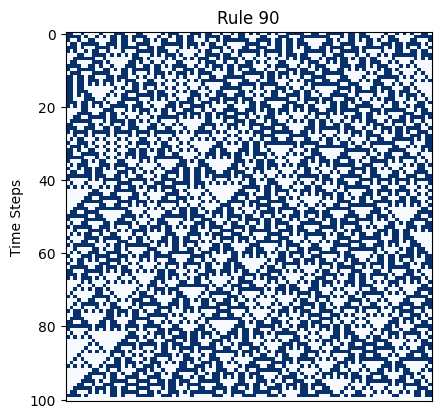

In [63]:
# Solution for Ex. 3 here...
def experiment(rule, floatp, arraylen, n_steps):
    title = f'Rule {rule}'
    ca = Cell1D(random_array(floatp, arraylen), rule)
    ca.simulate(n_steps)
    ca.draw(title)

experiment(90, 0.5, 100, 100)

#### Example code for creating grid of plots:

C:\Users\Watty\AppData\Local\Temp\ipykernel_12296\443470161.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, i)


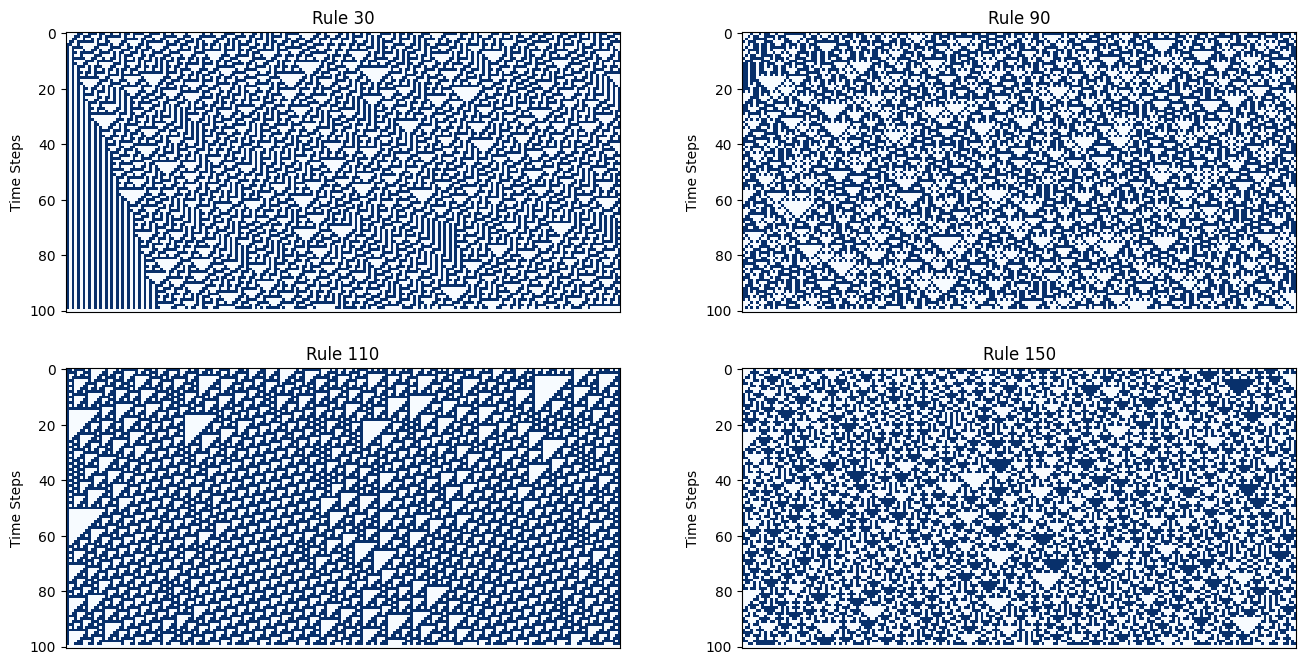

In [64]:
plt.subplots(figsize=(16, 8))   # total figure size for subplots is 16 x 8 inches
classrules = [30, 90, 110, 150]
# Example: plot 4 plots in a 2x2 grid - plots are number 1..4
for i in range(1,5):
    title = f'Rule {classrules[i-1]}'
    automata = Cell1D(random_array(0.5, 200), classrules[i-1])
    automata.simulate(100)
    plt.subplot(2, 2, i)
    automata.draw(title)

## Exercise 4:  Thought Experiments
Think about some of the questions that arise from this experiment.  Provide some concise answer that  capture you thinking...
1. What is it about these experiments that required computation?
Is there some other means by which we could conduct experiments like this?

2. What conclusions can you draw about the conditions under which complex behaviours can arise?
Do you think these conclusions are mostly intuitive or counter-intuitive?

3. What lessons might we take about studying complex phenomena in the real world from our study of elementary cellular automata?

### Answers
(concise, point-form -- there are no wrong answers, I'd just like to hear what you think)

1. While it's possible to compute these by hand, it'd likely have taken me the entire day, whereas computation generated these results virtually immediately. When it comes to large scale simulations, computation is practically essential in order to generate any results in which patterns can be seen.

2. Complex behaviours don't appear for quite a while; it's easier to observe them with more steps and a larger array as a starting state, though. 

3. With enough data, even in seemingly random structures and phenomena, it might be possible to find an algorithm that leads to that phenomena / behaviour / structures. Without being able to observe stuff at a large enough scale, though, we won't be able to derive anything. 